In [1]:
# Add the directory to sys.path
import sys
sys.path.append('/scratch/project_2010376')

In [10]:
import os
import cv2
import pydicom
import pywt
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

# Paths
DATA_DIR = '/scratch/project_2010376/vinbigdata-chest-xray-abnormalities-detection'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
PROCESSED_TRAIN_DIR = os.path.join(DATA_DIR, 'processed_train')

# Create processed_train directory if it doesn't exist
os.makedirs(PROCESSED_TRAIN_DIR, exist_ok=True)

# Preprocessing params
NLM_H = 30
NLM_TEMPLATE_WINDOW_SIZE = 7
NLM_SEARCH_WINDOW_SIZE = 21
CLAHE_CLIP_LIMIT = 2.0
CLAHE_TILE_GRID_SIZE = (8, 8)
WAVELET = 'haar'

def convert_to_8bit(image):
    """Normalize and convert image to 8-bit."""
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def apply_nlm_filtering(image):
    """Apply Non-local Means Denoising."""
    return cv2.fastNlMeansDenoising(image, None, NLM_H, NLM_TEMPLATE_WINDOW_SIZE, NLM_SEARCH_WINDOW_SIZE)

def apply_clahe_dwt(image):
    """Apply CLAHE and DWT."""
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP_LIMIT, tileGridSize=CLAHE_TILE_GRID_SIZE)
    cl1 = clahe.apply(image)
    coeffs2 = pywt.dwt2(cl1, WAVELET)
    LL, (LH, HL, HH) = coeffs2
    return LL

def load_dicom_image(file_path):
    """Load DICOM using pydicom."""
    try:
        dicom_data = pydicom.dcmread(file_path)
        image = dicom_data.pixel_array.astype(np.float32)
        
        # Windowing (optional): improve visibility for X-ray
        intercept = getattr(dicom_data, "RescaleIntercept", 0.0)
        slope = getattr(dicom_data, "RescaleSlope", 1.0)
        image = (image * slope) + intercept
        
        # Normalize to 0-255 and convert to 8-bit
        image = convert_to_8bit(image)
        return image
    except Exception as e:
        print(f"⚠️ Failed to load DICOM: {file_path}, Error: {e}")
        return None

def process_image(input_filepath, output_filepath):
    """Process one image and save output."""
    ext = os.path.splitext(input_filepath)[-1].lower()
    
    if ext in ['.dcm', '.dicom']:
        image = load_dicom_image(input_filepath)
    else:
        image = cv2.imread(input_filepath, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        return False

    try:
        # Apply preprocessing
        nlm_filtered = apply_nlm_filtering(image)
        clahe_dwt = apply_clahe_dwt(nlm_filtered)
        
        # Save as PNG
        plt.imsave(output_filepath, clahe_dwt, cmap='gray')
        return True
    except Exception as e:
        print(f"⚠️ Error processing {input_filepath}: {e}")
        return False

def process_all_images(input_dir, output_dir):
    """Process all images in a directory."""
    files = sorted(os.listdir(input_dir))
    print(f"📂 Found {len(files)} files in {input_dir}")

    processed_count = 0

    for filename in tqdm(files):
        input_filepath = os.path.join(input_dir, filename)
        output_filename = os.path.splitext(filename)[0] + '.png'
        output_filepath = os.path.join(output_dir, output_filename)

        if os.path.exists(output_filepath):
            continue
        
        success = process_image(input_filepath, output_filepath)
        if success:
            processed_count += 1

    print(f"✅ Completed processing {processed_count} images out of {len(files)}")

# RUN preprocessing
process_all_images(TRAIN_DIR, PROCESSED_TRAIN_DIR)


📂 Found 15000 files in /scratch/project_2010376/vinbigdata-chest-xray-abnormalities-detection/train


100%|██████████| 15000/15000 [3:48:30<00:00,  1.09it/s]  

✅ Completed processing 15000 images out of 15000


In [11]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm

# Directories
BASE_DIR = '/scratch/project_2010376/vinbigdata-chest-xray-abnormalities-detection'
PROCESSED_TRAIN_DIR = os.path.join(BASE_DIR, 'processed_train')
PATCHED_TRAIN_DIR = os.path.join(BASE_DIR, 'patched_train')

# Create the patched_train directory if not exist
os.makedirs(PATCHED_TRAIN_DIR, exist_ok=True)

# Parameters
PATCH_SIZE = 64
BALANCE_CLASSES = True  # If True, will undersample majority class

# Read the CSV with annotations
df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))

# Mappings for binary classification
CATEGORY_MAPPING = {
    14: 'No finding',      # Class 14 in VinBigData dataset
    12: 'Pneumothorax'     # Class 12 (for Pneumonia detection task)
}

def extract_patches(image_id, bboxes, class_id):
    """Extract patches from image using bounding boxes."""
    patches = []
    
    # Load processed image
    image_path = os.path.join(PROCESSED_TRAIN_DIR, f"{image_id}.png")
    if not os.path.exists(image_path):
        print(f"⚠️ Processed image not found: {image_path}")
        return patches
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"⚠️ Failed to load processed image: {image_path}")
        return patches

    # If bboxes exist, extract patches
    if len(bboxes) > 0:
        for idx, (x_min, y_min, x_max, y_max) in enumerate(bboxes):
            patch = image[int(y_min):int(y_max), int(x_min):int(x_max)]

            # Skip if patch size is smaller than threshold
            if patch.shape[0] < PATCH_SIZE or patch.shape[1] < PATCH_SIZE:
                continue
            
            # Resize patch
            patch_resized = cv2.resize(patch, (PATCH_SIZE, PATCH_SIZE))
            patches.append((patch_resized, class_id))

    return patches

# Containers for patches
normal_patches = []
pneumonia_patches = []

# Process each image
image_ids = df['image_id'].unique()

print(f"📂 Found {len(image_ids)} unique images to process...")

for image_id in tqdm(image_ids):
    group = df[df['image_id'] == image_id]
    
    # Get all bbox + class_id
    bboxes = group[['x_min', 'y_min', 'x_max', 'y_max']].dropna().values
    class_ids = group['class_id'].dropna().values.astype(int)

    # If "No finding" exists, we process entire image as 'normal'
    if 14 in class_ids or len(bboxes) == 0:
        image_path = os.path.join(PROCESSED_TRAIN_DIR, f"{image_id}.png")
        if os.path.exists(image_path):
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue
            patch_resized = cv2.resize(image, (PATCH_SIZE, PATCH_SIZE))
            normal_patches.append(patch_resized)
    else:
        # Only keep patches with Pneumothorax (class 12)
        pneumo_bboxes = []
        for bbox, cid in zip(bboxes, class_ids):
            if cid == 12:
                pneumo_bboxes.append(bbox)

        patches = extract_patches(image_id, pneumo_bboxes, class_id=12)
        pneumonia_patches.extend([patch for patch, _ in patches])

# Balance classes (undersample if required)
num_normal = len(normal_patches)
num_pneumonia = len(pneumonia_patches)

print(f"✅ Patches extracted:\n  Normal: {num_normal}\n  Pneumonia: {num_pneumonia}")

if BALANCE_CLASSES:
    min_count = min(num_normal, num_pneumonia)
    print(f"🔧 Balancing classes to {min_count} samples each...")

    np.random.shuffle(normal_patches)
    np.random.shuffle(pneumonia_patches)

    normal_patches = normal_patches[:min_count]
    pneumonia_patches = pneumonia_patches[:min_count]

# Save patches to patched_train directory
def save_patches(patches, label):
    label_dir = os.path.join(PATCHED_TRAIN_DIR, label)
    os.makedirs(label_dir, exist_ok=True)

    for idx, patch in enumerate(patches):
        file_path = os.path.join(label_dir, f"{label}_{idx}.png")
        cv2.imwrite(file_path, patch)

print(f"💾 Saving patches...")
save_patches(normal_patches, "NORMAL")
save_patches(pneumonia_patches, "PNEUMONIA")

print("✅ Patch extraction and saving completed!")
print(f"🔎 NORMAL patches: {len(normal_patches)}")
print(f"🔎 PNEUMONIA patches: {len(pneumonia_patches)}")


📂 Found 15000 unique images to process...


100%|██████████| 15000/15000 [20:05<00:00, 12.45it/s]


✅ Patches extracted:
  Normal: 10606
  Pneumonia: 124
🔧 Balancing classes to 124 samples each...
💾 Saving patches...
✅ Patch extraction and saving completed!
🔎 NORMAL patches: 124
🔎 PNEUMONIA patches: 124


In [12]:
import os

MODELS_DIR = '/scratch/project_2010376/models'
HISTORIES_DIR = '/scratch/project_2010376/histories'

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(HISTORIES_DIR, exist_ok=True)

print("✅ Folders ready for saving models and histories.")


✅ Folders ready for saving models and histories.


In [14]:
import os
import pandas as pd
import cv2
from tqdm import tqdm

# Paths
DATA_DIR = '/scratch/project_2010376/vinbigdata-chest-xray-abnormalities-detection'
TRAIN_CSV_PATH = os.path.join(DATA_DIR, 'train.csv')
PROCESSED_TRAIN_DIR = os.path.join(DATA_DIR, 'processed_train')
PATCHED_TRAIN_DIR = os.path.join(DATA_DIR, 'patched_train')

PATCH_SIZE = 64

# Pneumonia class IDs from VinBigData labels
PNEUMONIA_CLASSES = [4, 6, 7, 12]  # Consolidation, Infiltration, Lung Opacity, Pneumothorax

# Create folders
os.makedirs(os.path.join(PATCHED_TRAIN_DIR, 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(PATCHED_TRAIN_DIR, 'PNEUMONIA'), exist_ok=True)

# Load train.csv
df = pd.read_csv(TRAIN_CSV_PATH)

def extract_patches():
    pneumonia_count = 0
    normal_count = 0
    processed_images = set()

    image_ids = df['image_id'].unique()
    print(f"🔍 Found {len(image_ids)} unique images to process...")

    for image_id in tqdm(image_ids):
        image_path = os.path.join(PROCESSED_TRAIN_DIR, f"{image_id}.png")

        if not os.path.exists(image_path):
            print(f"⚠️ Processed image not found: {image_path}")
            continue

        # Read image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"⚠️ Failed to load: {image_path}")
            continue

        # Extract bboxes and classes
        image_df = df[df['image_id'] == image_id]
        class_ids = image_df['class_id'].tolist()

        if any([cls in PNEUMONIA_CLASSES for cls in class_ids]):
            # Pneumonia case
            for idx, row in image_df.iterrows():
                cls_id = row['class_id']
                if cls_id not in PNEUMONIA_CLASSES:
                    continue

                bbox = [row['x_min'], row['y_min'], row['x_max'], row['y_max']]
                if pd.isnull(bbox).any():
                    continue

                x_min, y_min, x_max, y_max = map(int, bbox)
                patch = image[y_min:y_max, x_min:x_max]

                if patch.shape[0] >= PATCH_SIZE and patch.shape[1] >= PATCH_SIZE:
                    patch_resized = cv2.resize(patch, (PATCH_SIZE, PATCH_SIZE))
                    filename = f"{image_id}_{idx}_pneumonia.png"
                    cv2.imwrite(os.path.join(PATCHED_TRAIN_DIR, 'PNEUMONIA', filename), patch_resized)
                    pneumonia_count += 1
        else:
            # Normal case
            if image.shape[0] >= PATCH_SIZE and image.shape[1] >= PATCH_SIZE:
                patch_resized = cv2.resize(image, (PATCH_SIZE, PATCH_SIZE))
                filename = f"{image_id}_normal.png"
                cv2.imwrite(os.path.join(PATCHED_TRAIN_DIR, 'NORMAL', filename), patch_resized)
                normal_count += 1

        processed_images.add(image_id)

    print("✅ Patch extraction completed.")
    print(f"🔎 NORMAL patches: {normal_count}")
    print(f"🔎 PNEUMONIA patches: {pneumonia_count}")

extract_patches()


🔍 Found 15000 unique images to process...


100%|██████████| 15000/15000 [21:39<00:00, 11.54it/s]

✅ Patch extraction completed.
🔎 NORMAL patches: 13373
🔎 PNEUMONIA patches: 2184


In [15]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

AUGMENTED_TRAIN_DIR = os.path.join(DATA_DIR, 'patched_train_augmented')

# Create directories
os.makedirs(os.path.join(AUGMENTED_TRAIN_DIR, 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(AUGMENTED_TRAIN_DIR, 'PNEUMONIA'), exist_ok=True)

# Setup ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    fill_mode='reflect'
)

def augment_class(class_name, augment_times=10):
    input_folder = os.path.join(PATCHED_TRAIN_DIR, class_name)
    output_folder = os.path.join(AUGMENTED_TRAIN_DIR, class_name)

    images = [f for f in os.listdir(input_folder) if f.endswith('.png')]
    print(f"🔍 Found {len(images)} images in {class_name}...")

    for img_name in tqdm(images):
        img_path = os.path.join(input_folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        img = np.expand_dims(img, axis=-1)  # Add channel dimension
        img = np.expand_dims(img, axis=0)   # Add batch dimension

        # Save original
        cv2.imwrite(os.path.join(output_folder, img_name), img.squeeze())

        # Generate augmented images
        i = 0
        for batch in datagen.flow(img, batch_size=1):
            aug_img = batch[0].astype('uint8').squeeze()
            aug_filename = f"{os.path.splitext(img_name)[0]}_aug_{i}.png"
            cv2.imwrite(os.path.join(output_folder, aug_filename), aug_img)
            i += 1
            if i >= augment_times:
                break

# Augment both classes
augment_class('NORMAL', augment_times=10)
augment_class('PNEUMONIA', augment_times=10)

print("✅ Data augmentation completed!")


🔍 Found 13497 images in NORMAL...


100%|██████████| 13497/13497 [03:50<00:00, 58.59it/s]


🔍 Found 2308 images in PNEUMONIA...


100%|██████████| 2308/2308 [00:39<00:00, 58.23it/s]

✅ Data augmentation completed!


In [17]:
def load_augmented_data(directory, image_size=(64, 64)):
    images = []
    labels = []
    category_mapping = {
        "NORMAL": 0,
        "PNEUMONIA": 1
    }

    for class_name, label in category_mapping.items():
        class_dir = os.path.join(directory, class_name)
        files = [f for f in os.listdir(class_dir) if f.endswith('.png')]
        print(f"Loading {class_name}: {len(files)} images...")

        for file in tqdm(files):
            img_path = os.path.join(class_dir, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            img = cv2.resize(img, image_size)
            img = img / 255.0
            img = np.expand_dims(img, axis=-1)
            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(f"✅ Dataset loaded. Total samples: {len(labels)}")
    return images, labels

# Load augmented data
AUG_PATCHED_TRAIN_DIR = '/scratch/project_2010376/vinbigdata-chest-xray-abnormalities-detection/patched_train_augmented'
images, labels = load_augmented_data(AUG_PATCHED_TRAIN_DIR, image_size=(64, 64))

# One-hot encode labels
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels)


Loading NORMAL: 148467 images...


100%|██████████| 148467/148467 [50:29<00:00, 49.00it/s] 


Loading PNEUMONIA: 25388 images...


100%|██████████| 25388/25388 [08:47<00:00, 48.11it/s]


✅ Dataset loaded. Total samples: 173855


In [19]:
def balance_data(images, labels, normal_label=0, pneumonia_label=1):
    normal_indices = np.where(np.argmax(labels, axis=1) == normal_label)[0]
    pneumonia_indices = np.where(np.argmax(labels, axis=1) == pneumonia_label)[0]

    # Match NORMAL to PNEUMONIA size
    np.random.shuffle(normal_indices)
    balanced_normal_indices = normal_indices[:len(pneumonia_indices)]

    balanced_indices = np.concatenate([balanced_normal_indices, pneumonia_indices])
    np.random.shuffle(balanced_indices)

    return images[balanced_indices], labels[balanced_indices]

# Balance dataset now
balanced_images, balanced_labels = balance_data(images, labels)
print(f"✅ Balanced dataset: {balanced_images.shape[0]} samples")


✅ Balanced dataset: 50776 samples


In [20]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def residual_block(x, filters, kernel_size=3):
    shortcut = x

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

def create_model(input_shape=(64, 64, 1), num_classes=2):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = residual_block(x, 32)
    x = MaxPooling2D()(x)

    x = residual_block(x, 64)
    x = MaxPooling2D()(x)

    x = residual_block(x, 128)
    x = MaxPooling2D()(x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [22]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

def residual_block(x, filters, kernel_size=(3, 3)):
    shortcut = x
    
    # Conv path
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Project shortcut if needed
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add skip connection
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    
    return x

def create_model(input_shape=(64, 64, 1), num_classes=2):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = residual_block(x, 32)
    x = MaxPooling2D()(x)

    x = residual_block(x, 64)
    x = MaxPooling2D()(x)

    x = residual_block(x, 128)
    x = MaxPooling2D()(x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    return model


In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1

y_labels = np.argmax(balanced_labels, axis=1)

for train_index, val_index in kfold.split(balanced_images, y_labels):
    print(f"\n🚀 Starting Fold {fold_no}...\n")

    X_train, X_val = balanced_images[train_index], balanced_images[val_index]
    y_train, y_val = balanced_labels[train_index], balanced_labels[val_index]

    # Create model
    model = create_model()  
    
    # ✅ Compile model BEFORE fitting
    model.compile(
        optimizer=Adam(learning_rate=1e-4),  
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    checkpoint = ModelCheckpoint(f'/scratch/project_2010376/models/cnn_model_fold_{fold_no}.keras',
                                 monitor='val_accuracy', save_best_only=True, mode='max')
    early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)

    # ✅ Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[checkpoint, early_stop, reduce_lr]
    )

    print(f"✅ Fold {fold_no} Completed!")
    fold_no += 1



🚀 Starting Fold 1...

Epoch 1/50
635/635 ━━━━━━━━━━━━━━━━━━━━ 405s 625ms/step - accuracy: 0.8873 - loss: 0.2589 - val_accuracy: 0.9588 - val_loss: 0.1244 - learning_rate: 1.0000e-04
Epoch 2/50
635/635 ━━━━━━━━━━━━━━━━━━━━ 407s 641ms/step - accuracy: 0.9910 - loss: 0.0279 - val_accuracy: 0.9826 - val_loss: 0.0586 - learning_rate: 1.0000e-04
Epoch 3/50
635/635 ━━━━━━━━━━━━━━━━━━━━ 418s 659ms/step - accuracy: 0.9948 - loss: 0.0170 - val_accuracy: 0.9950 - val_loss: 0.0166 - learning_rate: 1.0000e-04
Epoch 4/50
635/635 ━━━━━━━━━━━━━━━━━━━━ 423s 666ms/step - accuracy: 0.9970 - loss: 0.0099 - val_accuracy: 0.9954 - val_loss: 0.0158 - learning_rate: 1.0000e-04
Epoch 5/50
635/635 ━━━━━━━━━━━━━━━━━━━━ 428s 673ms/step - accuracy: 0.9978 - loss: 0.0069 - val_accuracy: 0.9979 - val_loss: 0.0062 - learning_rate: 1.0000e-04
Epoch 6/50
635/635 ━━━━━━━━━━━━━━━━━━━━ 431s 679ms/step - accuracy: 0.9985 - loss: 0.0050 - val_accuracy: 0.9982 - val_loss: 0.0059 - learning_rate: 1.0000e-04
Epoch 7/50
635/63

In [28]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical


In [29]:
GUANGZHOU_ROOT_DIR = '/scratch/project_2010376/Guangzhou_X_ray_dataset/chest_xray'
GUANGZHOU_TRAIN_DIR = os.path.join(GUANGZHOU_ROOT_DIR, 'train')
GUANGZHOU_VAL_DIR = os.path.join(GUANGZHOU_ROOT_DIR, 'val')
GUANGZHOU_TEST_DIR = os.path.join(GUANGZHOU_ROOT_DIR, 'test')


In [36]:
import os
import cv2
import numpy as np
import pywt
from tqdm import tqdm
from matplotlib import pyplot as plt

# Constants (adjust if needed)
NLM_H = 30
NLM_TEMPLATE_WINDOW_SIZE = 7
NLM_SEARCH_WINDOW_SIZE = 21
CLAHE_CLIP_LIMIT = 2.0
CLAHE_TILE_GRID_SIZE = (8, 8)
WAVELET = 'haar'

# Input & Output paths
INPUT_BASE_DIR = '/scratch/project_2010376/Guangzhou_X_ray_dataset/chest_xray'
OUTPUT_BASE_DIR = '/scratch/project_2010376/Guangzhou_X_ray_dataset/processed_chest_xray'

# Ensure output directories exist
for folder in ['train', 'val', 'test']:
    for label in ['NORMAL', 'PNEUMONIA']:
        os.makedirs(os.path.join(OUTPUT_BASE_DIR, folder, label), exist_ok=True)

# Define preprocessing functions
def convert_to_8bit(image):
    """Normalize and convert image to 8-bit."""
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def apply_nlm_filtering(image):
    """Non-local means denoising."""
    return cv2.fastNlMeansDenoising(image, None, NLM_H, NLM_TEMPLATE_WINDOW_SIZE, NLM_SEARCH_WINDOW_SIZE)

def apply_clahe_dwt(image):
    """CLAHE followed by DWT (returns the LL band)."""
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP_LIMIT, tileGridSize=CLAHE_TILE_GRID_SIZE)
    clahe_img = clahe.apply(image)
    coeffs2 = pywt.dwt2(clahe_img, WAVELET)
    LL, (LH, HL, HH) = coeffs2
    return LL

def preprocess_image(image_path):
    """Run all preprocessing steps."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load: {image_path}")
        return None
    
    img_8bit = convert_to_8bit(img)
    img_nlm = apply_nlm_filtering(img_8bit)
    img_clahe_dwt = apply_clahe_dwt(img_nlm)
    
    
    processed_img = cv2.resize(img_clahe_dwt, (64, 64))
    
    return processed_img

# Process all images in folder
def process_dataset(subfolder):
    input_dir = os.path.join(INPUT_BASE_DIR, subfolder)
    output_dir = os.path.join(OUTPUT_BASE_DIR, subfolder)

    for class_label in ['NORMAL', 'PNEUMONIA']:
        input_class_dir = os.path.join(input_dir, class_label)
        output_class_dir = os.path.join(output_dir, class_label)
        
        print(f"🔄 Processing {subfolder}/{class_label}...")

        image_files = [f for f in os.listdir(input_class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for img_file in tqdm(image_files):
            input_img_path = os.path.join(input_class_dir, img_file)
            output_img_path = os.path.join(output_class_dir, img_file)

            processed_img = preprocess_image(input_img_path)
            if processed_img is not None:
                cv2.imwrite(output_img_path, processed_img)

# Process train, val, and test sets
for folder in ['train', 'val', 'test']:
    process_dataset(folder)

print("✅ Preprocessing complete!")


🔄 Processing train/NORMAL...


100%|██████████| 1341/1341 [03:41<00:00,  6.06it/s]


🔄 Processing train/PNEUMONIA...


100%|██████████| 3875/3875 [08:17<00:00,  7.79it/s]


🔄 Processing val/NORMAL...


100%|██████████| 8/8 [00:01<00:00,  7.11it/s]


🔄 Processing val/PNEUMONIA...


100%|██████████| 8/8 [00:01<00:00,  7.85it/s]


🔄 Processing test/NORMAL...


100%|██████████| 234/234 [00:38<00:00,  6.06it/s]


🔄 Processing test/PNEUMONIA...


100%|██████████| 390/390 [00:49<00:00,  7.82it/s]

✅ Preprocessing complete!


In [42]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

def load_processed_guangzhou_data(base_dir, image_size=(64, 64)):
    images = []
    labels = []
    
    class_map = {
        'NORMAL': 0,
        'PNEUMONIA': 1
    }

    # Iterate over train, val, and test folders
    for dataset_type in ['train', 'val', 'test']:
        print(f"\n🔎 Processing folder: {dataset_type}...")

        for label_name, label_id in class_map.items():
            img_dir = os.path.join(base_dir, dataset_type, label_name)

            if not os.path.exists(img_dir):
                print(f"❌ Folder not found: {img_dir}")
                continue

            img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            print(f"📂 Loading {len(img_files)} images from {dataset_type}/{label_name}...")

            for img_file in tqdm(img_files, desc=f'{dataset_type}/{label_name}'):
                img_path = os.path.join(img_dir, img_file)

                # Read the image
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img is None:
                    print(f"⚠️ Failed to load: {img_path}")
                    continue

                # Resize and normalize
                img = cv2.resize(img, image_size)
                img = img / 255.0
                img = np.expand_dims(img, axis=-1)  # Add channel dimension

                images.append(img)
                labels.append(label_id)

    images = np.array(images)
    labels = np.array(labels)

    # Convert labels to categorical
    labels_cat = to_categorical(labels)

    print(f"\n✅ Loaded {len(images)} images in total from Guangzhou processed dataset.")
    print(f"Class distribution: NORMAL = {np.sum(labels == 0)}, PNEUMONIA = {np.sum(labels == 1)}")

    return images, labels_cat


processed_guangzhou_dir = '/scratch/project_2010376/Guangzhou_X_ray_dataset/processed_chest_xray'

# Load data
guangzhou_images, guangzhou_labels = load_processed_guangzhou_data(processed_guangzhou_dir, image_size=(64, 64))

print(f"🖼️ Images shape: {guangzhou_images.shape}")
print(f"🏷️ Labels shape: {guangzhou_labels.shape}")



🔎 Processing folder: train...
📂 Loading 1341 images from train/NORMAL...


train/NORMAL: 100%|██████████| 1341/1341 [00:23<00:00, 57.50it/s]


📂 Loading 3875 images from train/PNEUMONIA...


train/PNEUMONIA: 100%|██████████| 3875/3875 [01:01<00:00, 63.18it/s]



🔎 Processing folder: val...
📂 Loading 8 images from val/NORMAL...


val/NORMAL: 100%|██████████| 8/8 [00:00<00:00, 53.56it/s]


📂 Loading 8 images from val/PNEUMONIA...


val/PNEUMONIA: 100%|██████████| 8/8 [00:00<00:00, 56.42it/s]



🔎 Processing folder: test...
📂 Loading 234 images from test/NORMAL...


test/NORMAL: 100%|██████████| 234/234 [00:03<00:00, 64.84it/s]


📂 Loading 390 images from test/PNEUMONIA...


test/PNEUMONIA: 100%|██████████| 390/390 [00:06<00:00, 63.14it/s]


✅ Loaded 5856 images in total from Guangzhou processed dataset.
Class distribution: NORMAL = 1583, PNEUMONIA = 4273
🖼️ Images shape: (5856, 64, 64, 1)
🏷️ Labels shape: (5856, 2)


In [43]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('/scratch/project_2010376/models/cnn_model_fold_1.keras')

# Predict on Guangzhou dataset
predictions = best_model.predict(guangzhou_images)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(guangzhou_labels, axis=1)

# Evaluate accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(true_classes, predicted_classes)
print(f"✅ Guangzhou Dataset Accuracy: {accuracy:.4f}")

# Detailed report
print(classification_report(true_classes, predicted_classes, target_names=['NORMAL', 'PNEUMONIA']))

# Confusion Matrix
print(confusion_matrix(true_classes, predicted_classes))


183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
✅ Guangzhou Dataset Accuracy: 0.3011
              precision    recall  f1-score   support

      NORMAL       0.28      1.00      0.44      1583
   PNEUMONIA       0.96      0.04      0.08      4273

    accuracy                           0.30      5856
   macro avg       0.62      0.52      0.26      5856
weighted avg       0.78      0.30      0.18      5856

[[1576    7]
 [4086  187]]


In [44]:
##

In [45]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam


model = load_model('/scratch/project_2010376/models/cnn_model_fold_1.keras')


model.compile(optimizer=Adam(learning_rate=1e-5),  # Fine-tuning LR
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [46]:

guangzhou_images, guangzhou_labels = load_processed_guangzhou_data(
    '/scratch/project_2010376/Guangzhou_X_ray_dataset/processed_chest_xray',
    image_size=(64, 64)
)




🔎 Processing folder: train...
📂 Loading 1341 images from train/NORMAL...


train/NORMAL: 100%|██████████| 1341/1341 [00:00<00:00, 2225.09it/s]


📂 Loading 3875 images from train/PNEUMONIA...


train/PNEUMONIA: 100%|██████████| 3875/3875 [00:01<00:00, 2255.52it/s]



🔎 Processing folder: val...
📂 Loading 8 images from val/NORMAL...


val/NORMAL: 100%|██████████| 8/8 [00:00<00:00, 2222.74it/s]


📂 Loading 8 images from val/PNEUMONIA...


val/PNEUMONIA: 100%|██████████| 8/8 [00:00<00:00, 2203.90it/s]



🔎 Processing folder: test...
📂 Loading 234 images from test/NORMAL...


test/NORMAL: 100%|██████████| 234/234 [00:00<00:00, 2248.66it/s]


📂 Loading 390 images from test/PNEUMONIA...


test/PNEUMONIA: 100%|██████████| 390/390 [00:00<00:00, 2269.16it/s]



✅ Loaded 5856 images in total from Guangzhou processed dataset.
Class distribution: NORMAL = 1583, PNEUMONIA = 4273


In [ ]:
#k fold on ghuanzhou

In [ ]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Define a simple CNN model as a placeholder (update with your final model if needed)
def create_model(input_shape=(600, 600, 1), num_classes=2):
    from tensorflow.keras import layers, models
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Function to load data from folders
def load_data(base_path):
    classes = ['NORMAL', 'PNEUMONIA']
    images = []
    labels = []
    
    print(f"Loading data from: {base_path}")
    
    for label, cls in enumerate(classes):
        folder = os.path.join(base_path, cls)
        files = os.listdir(folder)
        print(f" - {cls}: {len(files)} images")
        for img_file in files:
            img_path = os.path.join(folder, img_file)
            img = tf.keras.preprocessing.image.load_img(
                img_path, color_mode='grayscale', target_size=(600, 600)
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(label)
    
    images = np.array(images)
    labels = to_categorical(np.array(labels), num_classes=2)
    return images, labels

# Load Guangzhou dataset
train_path = '/scratch/project_2010376/Guangzhou_X_ray_dataset/processed_chest_xray/train'
val_path = '/scratch/project_2010376/Guangzhou_X_ray_dataset/processed_chest_xray/val'

train_images, train_labels = load_data(train_path)
val_images, val_labels = load_data(val_path)

# Combine train and val sets
balanced_images = np.concatenate([train_images, val_images])
balanced_labels = np.concatenate([train_labels, val_labels])

y_labels = np.argmax(balanced_labels, axis=1)

# Set up Stratified K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1

# Performance metrics storage
fold_accuracies = []
fold_aurocs = []
fold_precisions = []
fold_recalls = []

for train_index, val_index in kfold.split(balanced_images, y_labels):
    print(f"\n🚀 Starting Fold {fold_no}...\n")
    
    X_train, X_val = balanced_images[train_index], balanced_images[val_index]
    y_train, y_val = balanced_labels[train_index], balanced_labels[val_index]

    # Initialize and compile model
    model = create_model(input_shape=(600, 600, 1), num_classes=2)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks
    checkpoint_path = f'/scratch/project_2010376/models/cnn_model_fold_{fold_no}.keras'
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')
    early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[checkpoint, early_stop, reduce_lr],
        verbose=1
    )

    # Evaluate model on validation data
    val_preds_prob = model.predict(X_val)
    val_preds = np.argmax(val_preds_prob, axis=1)
    y_val_true = np.argmax(y_val, axis=1)

    acc = accuracy_score(y_val_true, val_preds)
    auroc = roc_auc_score(y_val, val_preds_prob)
    prec = precision_score(y_val_true, val_preds)
    rec = recall_score(y_val_true, val_preds)

    fold_accuracies.append(acc)
    fold_aurocs.append(auroc)
    fold_precisions.append(prec)
    fold_recalls.append(rec)

    print(f"✅ Fold {fold_no} Completed!")
    print(f" - Accuracy: {acc:.4f}")
    print(f" - AUROC: {auroc:.4f}")
    print(f" - Precision: {prec:.4f}")
    print(f" - Recall: {rec:.4f}")

    fold_no += 1

# Report aggregated results across all folds
print("\n=== K-Fold Cross Validation Results ===")
print(f"Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")
print(f"AUROC: {np.mean(fold_aurocs):.4f} (+/- {np.std(fold_aurocs):.4f})")
print(f"Precision: {np.mean(fold_precisions):.4f} (+/- {np.std(fold_precisions):.4f})")
print(f"Recall: {np.mean(fold_recalls):.4f} (+/- {np.std(fold_recalls):.4f})")

# Plot the cross-validation metrics
plt.figure(figsize=(12, 6))
plt.plot(range(1, 6), fold_accuracies, marker='o', label='Accuracy')
plt.plot(range(1, 6), fold_aurocs, marker='o', label='AUROC')
plt.plot(range(1, 6), fold_precisions, marker='o', label='Precision')
plt.plot(range(1, 6), fold_recalls, marker='o', label='Recall')
plt.xlabel('Fold')
plt.ylabel('Metric Value')
plt.title('Cross-Validation Metrics for Guangzhou Dataset')
plt.legend()
plt.grid(True)
plt.show()


Loading data from: /scratch/project_2010376/Guangzhou_X_ray_dataset/processed_chest_xray/train
 - NORMAL: 1341 images
 - PNEUMONIA: 3875 images
Loading data from: /scratch/project_2010376/Guangzhou_X_ray_dataset/processed_chest_xray/val
 - NORMAL: 8 images
 - PNEUMONIA: 8 images

🚀 Starting Fold 1...

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 336s 5s/step - accuracy: 0.6842 - loss: 1.1624 - val_accuracy: 0.9198 - val_loss: 0.2729 - learning_rate: 1.0000e-04
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 342s 5s/step - accuracy: 0.9108 - loss: 0.2366 - val_accuracy: 0.9494 - val_loss: 0.1546 - learning_rate: 1.0000e-04
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 329s 5s/step - accuracy: 0.9340 - loss: 0.1586 - val_accuracy: 0.9666 - val_loss: 0.0900 - learning_rate: 1.0000e-04
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 329s 5s/step - accuracy: 0.9644 - loss: 0.0888 - val_accuracy: 0.9713 - val_loss: 0.0831 - learning_rate: 1.0000e-04
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 327s 5s/step - accuracy: 0.9770 - loss:

In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-7)
checkpoint = ModelCheckpoint('/scratch/project_2010376/models/cnn_model_finetuned_guangzhou.keras',
                             monitor='val_accuracy', save_best_only=True, mode='max')

# Fine-tune the model
history = model.fit(guangzhou_images, guangzhou_labels,
                    validation_split=0.2,
                    epochs=20,
                    batch_size=64,
                    callbacks=[early_stop, reduce_lr, checkpoint])

# Save final model 
model.save('/scratch/project_2010376/models/cnn_model_finetuned_guangzhou_final.keras')


Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 50s 613ms/step - accuracy: 0.5699 - loss: 4.5097 - val_accuracy: 0.3285 - val_loss: 8.6239 - learning_rate: 1.0000e-05
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 48s 642ms/step - accuracy: 0.8141 - loss: 1.1971 - val_accuracy: 0.8217 - val_loss: 1.0442 - learning_rate: 1.0000e-05
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 48s 643ms/step - accuracy: 0.8835 - loss: 0.5465 - val_accuracy: 0.8268 - val_loss: 1.4096 - learning_rate: 1.0000e-05
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 49s 659ms/step - accuracy: 0.8986 - loss: 0.3880 - val_accuracy: 0.8276 - val_loss: 1.4108 - learning_rate: 1.0000e-05
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 50s 675ms/step - accuracy: 0.9093 - loss: 0.3000 - val_accuracy: 0.8208 - val_loss: 1.4215 - learning_rate: 1.0000e-05
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 51s 684ms/step - accuracy: 0.9202 - loss: 0.2662 - val_accuracy: 0.8268 - val_loss: 1.2795 - learning_rate: 1.0000e-05
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 50s 679ms/step - acc

In [48]:
# Evaluate on Guangzhou full dataset
eval_result = model.evaluate(guangzhou_images, guangzhou_labels)
print(f"✅ Fine-tuned Guangzhou Model Accuracy: {eval_result[1]:.4f}")


183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9492 - loss: 0.1360
✅ Fine-tuned Guangzhou Model Accuracy: 0.9423


In [ ]:
############# confused

In [68]:
import cv2
import pywt
import numpy as np

def preprocess_image(img, image_size=(64, 64)):
    # Convert to 8-bit
    img_8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # NLM filtering
    nlm_filtered = cv2.fastNlMeansDenoising(img_8bit, None, h=30, templateWindowSize=7, searchWindowSize=21)

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_applied = clahe.apply(nlm_filtered)

    # DWT
    coeffs2 = pywt.dwt2(clahe_applied, 'haar')
    LL, (LH, HL, HH) = coeffs2

    # Resize
    resized = cv2.resize(LL, image_size)

    # Normalize
    resized = resized / 255.0

    # Expand dims
    resized = np.expand_dims(resized, axis=-1)
    
    return resized


In [69]:
def load_and_preprocess_dataset(base_dir, image_size=(64, 64)):
    images = []
    labels = []
    class_map = {'normal': 0, 'pneumonia': 1}

    for label_name, label in class_map.items():
        folder_path = os.path.join(base_dir, label_name)

        if not os.path.exists(folder_path):
            print(f"⚠️ Folder missing: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpeg', '.jpg'))]

        print(f"🔎 Loading {label_name}: {len(files)} files...")

        for file in tqdm(files):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"❌ Failed loading {img_path}")
                continue

            # 🔧 Preprocess the image!
            processed_img = preprocess_image(img, image_size)

            images.append(processed_img)
            labels.append(label)

    images = np.array(images)
    labels = to_categorical(np.array(labels))

    print(f"✅ Loaded and preprocessed {len(images)} images from {base_dir}")
    return images, labels


In [70]:
from tensorflow.keras.models import load_model

# path to best fine-tuned model
best_model_path = '/scratch/project_2010376/models/cnn_model_finetuned_guangzhou_final.keras'
model = load_model(best_model_path)

print("✅ Model loaded successfully.")


✅ Model loaded successfully.


In [58]:
# Evaluate
loss, accuracy = model.evaluate(new_images, new_labels, verbose=2)
print(f"✅ Evaluation Accuracy on Pneumonia Analysis Dataset: {accuracy:.4f}")


96/96 - 3s - 35ms/step - accuracy: 0.5485 - loss: 2.5475
✅ Evaluation Accuracy on Pneumonia Analysis Dataset: 0.5485


In [59]:
# Predict probabilities
predictions = model.predict(new_images)

# Convert predictions to class labels (0 or 1)
predicted_classes = predictions.argmax(axis=1)

# Ground truth class labels (0 or 1)
true_classes = new_labels.argmax(axis=1)

# Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix

print("📊 Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=['NORMAL', 'PNEUMONIA']))

print("🟦 Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
📊 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.75      0.15      0.24      1525
   PNEUMONIA       0.53      0.95      0.68      1525

    accuracy                           0.55      3050
   macro avg       0.64      0.55      0.46      3050
weighted avg       0.64      0.55      0.46      3050

🟦 Confusion Matrix:
[[ 223 1302]
 [  75 1450]]


In [60]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convert one-hot labels back to single labels
y_labels = np.argmax(new_labels, axis=1)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_labels), y=y_labels)
class_weights_dict = dict(enumerate(class_weights))

print("✅ Computed class weights:", class_weights_dict)


✅ Computed class weights: {0: 1.0, 1: 1.0}


In [61]:
history = model.fit(
    new_images,
    new_labels,
    validation_split=0.2,  # or use a separate validation set
    epochs=20,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 669ms/step - accuracy: 0.7536 - loss: 1.0132 - val_accuracy: 0.6590 - val_loss: 1.2561 - learning_rate: 1.0000e-05
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 628ms/step - accuracy: 0.9077 - loss: 0.4216 - val_accuracy: 0.8377 - val_loss: 0.5975 - learning_rate: 1.0000e-05
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 655ms/step - accuracy: 0.9153 - loss: 0.3700 - val_accuracy: 0.8607 - val_loss: 0.5297 - learning_rate: 1.0000e-05
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 635ms/step - accuracy: 0.9212 - loss: 0.3149 - val_accuracy: 0.8738 - val_loss: 0.4926 - learning_rate: 1.0000e-05
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 657ms/step - accuracy: 0.9173 - loss: 0.3022 - val_accuracy: 0.8738 - val_loss: 0.4759 - learning_rate: 1.0000e-05
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 639ms/step - accuracy: 0.9287 - loss: 0.2650 - val_accuracy: 0.8754 - val_loss: 0.4658 - learning_rate: 1.0000e-05
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 617ms/step - acc

In [62]:
# Evaluate after training
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=2)
print(f"✅ Validation Accuracy: {val_accuracy:.4f}")


318/318 - 10s - 32ms/step - accuracy: 0.8286 - loss: 0.4686
✅ Validation Accuracy: 0.8286


In [63]:
predictions = model.predict(new_images)
predicted_classes = predictions.argmax(axis=1)

# Convert ground truth labels
true_classes = new_labels.argmax(axis=1)


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step


In [64]:
from sklearn.metrics import classification_report, confusion_matrix

print("📊 Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=['NORMAL', 'PNEUMONIA']))

print("🟦 Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))


📊 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.90      0.96      0.93      1525
   PNEUMONIA       0.96      0.89      0.92      1525

    accuracy                           0.93      3050
   macro avg       0.93      0.93      0.93      3050
weighted avg       0.93      0.93      0.93      3050

🟦 Confusion Matrix:
[[1465   60]
 [ 164 1361]]


In [71]:
print(f"✅ Dataset path: /scratch/project_2010376/Pneumonia_Analysis_Dataset")
print(f"✅ NORMAL folder: /scratch/project_2010376/Pneumonia_Analysis_Dataset/normal")
print(f"✅ PNEUMONIA folder: /scratch/project_2010376/Pneumonia_Analysis_Dataset/pneumonia")


✅ Dataset path: /scratch/project_2010376/Pneumonia_Analysis_Dataset
✅ NORMAL folder: /scratch/project_2010376/Pneumonia_Analysis_Dataset/normal
✅ PNEUMONIA folder: /scratch/project_2010376/Pneumonia_Analysis_Dataset/pneumonia


In [74]:
######independent dataset testing

✅ Dataset path: /scratch/project_2010376/Pneumonia_Analysis_Dataset
✅ NORMAL folder: /scratch/project_2010376/Pneumonia_Analysis_Dataset/normal
✅ PNEUMONIA folder: /scratch/project_2010376/Pneumonia_Analysis_Dataset/pneumonia
🔎 Loading normal: 1525 files from /scratch/project_2010376/Pneumonia_Analysis_Dataset/normal...


100%|██████████| 1525/1525 [04:23<00:00,  5.78it/s]


🔎 Loading pneumonia: 1525 files from /scratch/project_2010376/Pneumonia_Analysis_Dataset/pneumonia...


100%|██████████| 1525/1525 [03:20<00:00,  7.62it/s]


✅ Loaded and preprocessed 3050 images from /scratch/project_2010376/Pneumonia_Analysis_Dataset
📂 Sample loaded file paths:
 - /scratch/project_2010376/Pneumonia_Analysis_Dataset/normal/00000694_000.png
 - /scratch/project_2010376/Pneumonia_Analysis_Dataset/normal/00000781_008.png
 - /scratch/project_2010376/Pneumonia_Analysis_Dataset/normal/00000149_009.png
 - /scratch/project_2010376/Pneumonia_Analysis_Dataset/normal/00000919_000.png
 - /scratch/project_2010376/Pneumonia_Analysis_Dataset/normal/00000468_057.png
✅ Model loaded from: /scratch/project_2010376/models/cnn_model_finetuned_guangzhou_final.keras
✅ Computed class weights: {0: 1.0, 1: 1.0}
Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 635ms/step - accuracy: 0.8027 - loss: 0.6871 - val_accuracy: 0.1869 - val_loss: 6.0525 - learning_rate: 1.0000e-05
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 636ms/step - accuracy: 0.9062 - loss: 0.3875 - val_accuracy: 0.6049 - val_loss: 2.1340 - learning_rate: 1.0000e-05
Epoch 3/20
39/39 ━━━━━━━━━━━━━

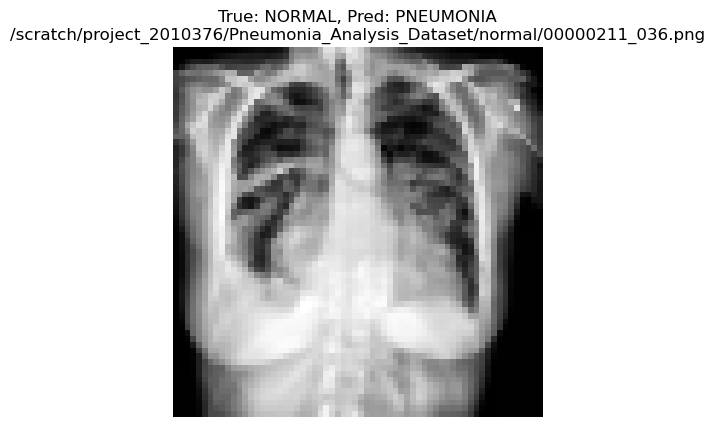

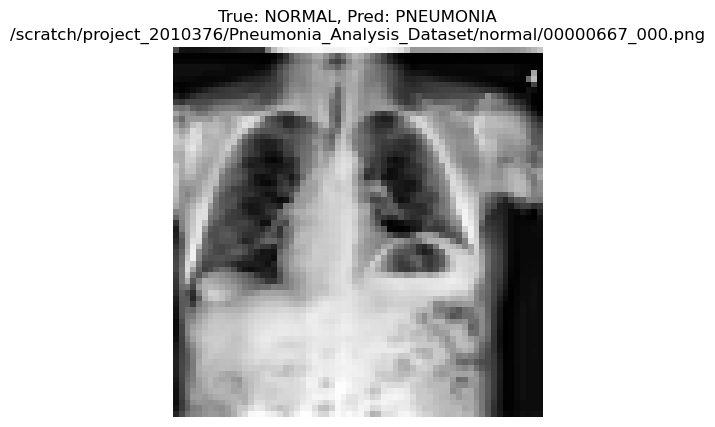

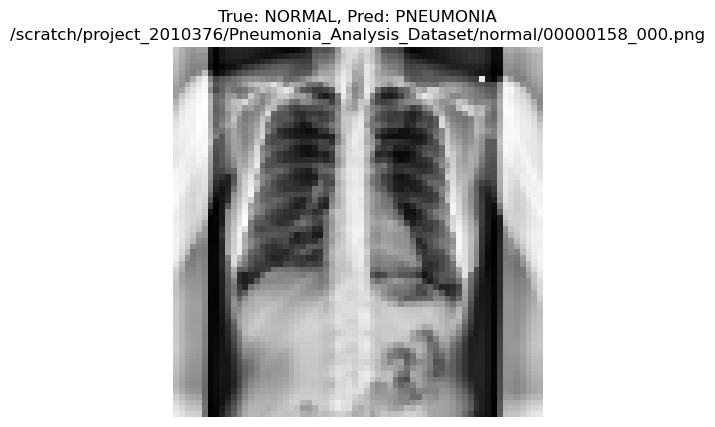

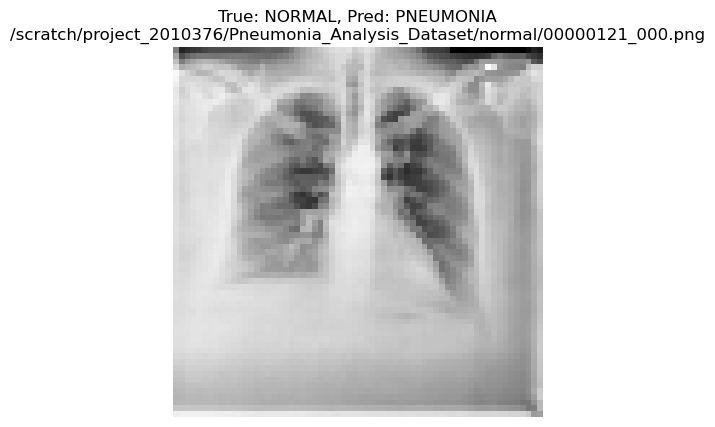

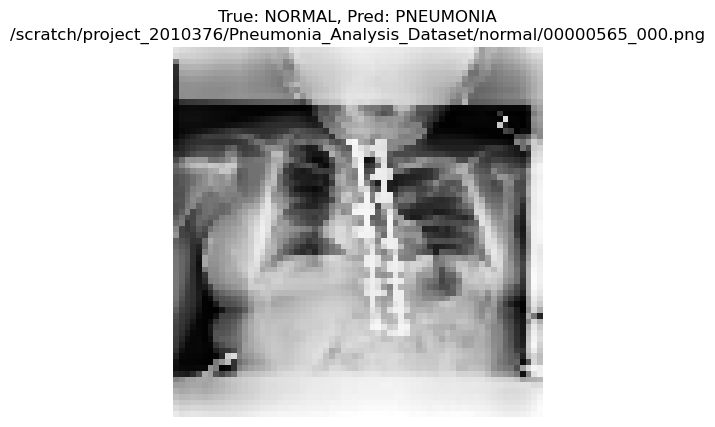

In [75]:
import os
import cv2
import pywt
import numpy as np
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# ==================================
# ✅ Confirm Dataset Paths
# ==================================
DATASET_DIR = '/scratch/project_2010376/Pneumonia_Analysis_Dataset'
NORMAL_DIR = os.path.join(DATASET_DIR, 'normal')
PNEUMONIA_DIR = os.path.join(DATASET_DIR, 'pneumonia')

print(f"✅ Dataset path: {DATASET_DIR}")
print(f"✅ NORMAL folder: {NORMAL_DIR}")
print(f"✅ PNEUMONIA folder: {PNEUMONIA_DIR}")

# ==================================
# ✅ Preprocess Function (NLM, CLAHE, DWT)
# ==================================
def preprocess_image(img, image_size=(64, 64)):
    # Convert to 8-bit
    img_8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # NLM filtering
    nlm_filtered = cv2.fastNlMeansDenoising(img_8bit, None, h=30, templateWindowSize=7, searchWindowSize=21)

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_applied = clahe.apply(nlm_filtered)

    # DWT
    coeffs2 = pywt.dwt2(clahe_applied, 'haar')
    LL, (LH, HL, HH) = coeffs2

    # Resize
    resized = cv2.resize(LL, image_size)

    # Normalize
    resized = resized / 255.0

    # Expand dims to match model input
    resized = np.expand_dims(resized, axis=-1)
    
    return resized

# ==================================
# ✅ Load and Preprocess Dataset (with file paths)
# ==================================
def load_and_preprocess_dataset_with_paths(base_dir, image_size=(64, 64)):
    images = []
    labels = []
    image_paths = []
    class_map = {'normal': 0, 'pneumonia': 1}

    for label_name, label in class_map.items():
        folder_path = os.path.join(base_dir, label_name)

        if not os.path.exists(folder_path):
            print(f"⚠️ Folder missing: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpeg', '.jpg'))]

        print(f"🔎 Loading {label_name}: {len(files)} files from {folder_path}...")

        for file in tqdm(files):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"❌ Failed loading {img_path}")
                continue

            # 🔧 Preprocess the image
            processed_img = preprocess_image(img, image_size)

            images.append(processed_img)
            labels.append(label)
            image_paths.append(img_path)

    images = np.array(images)
    labels = to_categorical(np.array(labels))

    print(f"✅ Loaded and preprocessed {len(images)} images from {base_dir}")
    return images, labels, image_paths

# ==================================
# ✅ Load Data
# ==================================
new_images, new_labels, image_paths = load_and_preprocess_dataset_with_paths(DATASET_DIR)

# Confirm samples
print("📂 Sample loaded file paths:")
for path in image_paths[:5]:
    print(f" - {path}")

# ==================================
# ✅ Load the Best Model
# ==================================
best_model_path = '/scratch/project_2010376/models/cnn_model_finetuned_guangzhou_final.keras'
model = load_model(best_model_path)
print(f"✅ Model loaded from: {best_model_path}")

# ==================================
# ✅ Compute Class Weights (to handle imbalance)
# ==================================
y_labels = np.argmax(new_labels, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_labels), y=y_labels)
class_weights_dict = dict(enumerate(class_weights))

print("✅ Computed class weights:", class_weights_dict)

# ==================================
# ✅ Fine-Tune or Evaluate
# ==================================

# Optional fine-tune if needed (comment out if not fine-tuning)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('/scratch/project_2010376/models/cnn_model_finetuned_analysis.keras',
                             monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-7)

history = model.fit(
    new_images,
    new_labels,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# ==================================
# ✅ Evaluate on the Entire Dataset
# ==================================
loss, accuracy = model.evaluate(new_images, new_labels, verbose=2)
print(f"✅ Evaluation Accuracy on Pneumonia Analysis Dataset: {accuracy:.4f}")

# ==================================
# ✅ Predict and Analyze Results
# ==================================
predictions = model.predict(new_images)
predicted_classes = predictions.argmax(axis=1)
true_classes = new_labels.argmax(axis=1)

print("📊 Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=['NORMAL', 'PNEUMONIA']))

print("🟦 Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))

# ==================================
# ✅ Optional: Show Some Misclassified Images
# ==================================
import matplotlib.pyplot as plt

misclassified_indices = np.where(predicted_classes != true_classes)[0]

if len(misclassified_indices) > 0:
    print(f"❗ Found {len(misclassified_indices)} misclassified samples.")
    for idx in misclassified_indices[:5]:  # Show first 5
        img = new_images[idx].squeeze()
        true_label = 'NORMAL' if true_classes[idx] == 0 else 'PNEUMONIA'
        pred_label = 'NORMAL' if predicted_classes[idx] == 0 else 'PNEUMONIA'
        path = image_paths[idx]

        plt.imshow(img, cmap='gray')
        plt.title(f"True: {true_label}, Pred: {pred_label}\n{path}")
        plt.axis('off')
        plt.show()
else:
    print("✅ No misclassified samples!")



In [76]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │        320 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │      9,248 │ activation_11[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │      9,248 │ activation_12[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_65 (Add)        │ (None, 64, 64,    │          0 │ activation_11[0]… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 64, 64,    │          0 │ add_65[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_54    │ (None, 32, 32,    │          0 │ activation_13[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_54… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │      2,112 │ max_pooling2d_54… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │     36,928 │ activation_14[0]

 Total params: 1,122,248 (4.28 MB)

 Trainable params: 373,634 (1.43 MB)

 Non-trainable params: 1,344 (5.25 KB)

 Optimizer params: 747,270 (2.85 MB)

/scratch/project_2010376/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_8']]
Received: inputs=Tensor(shape=(1, 64, 64, 1))
  warnings.warn(msg)


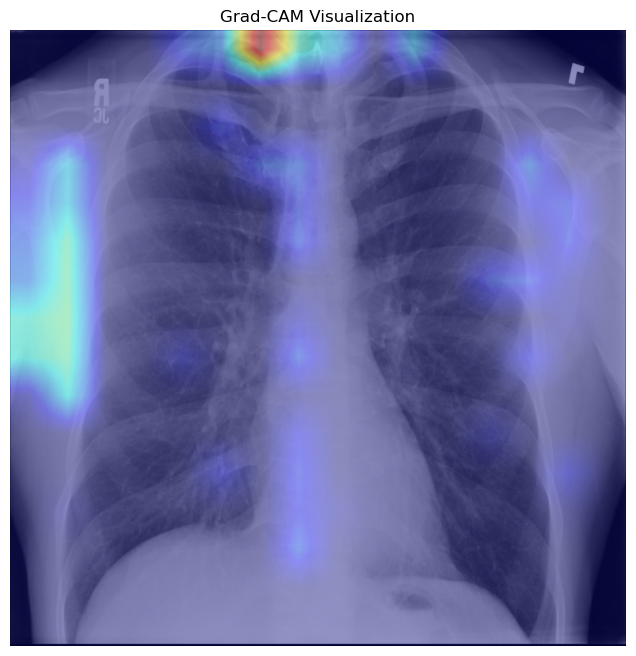

In [83]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Load the fine-tuned model
model_path = '/scratch/project_2010376/models/cnn_model_finetuned_guangzhou_final.keras'
model = tf.keras.models.load_model(model_path)

# Check image path exists
img_path = '/scratch/project_2010376/Pneumonia_Analysis_Dataset/normal/00000694_000.png'
if not os.path.exists(img_path):
    raise FileNotFoundError(f"❌ Image not found at: {img_path}")

# Grad-CAM functions (same as before)
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, model, last_conv_layer_name='conv2d_22', alpha=0.4):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"❌ Failed to load image at: {img_path}")

    img_resized = cv2.resize(img, (64, 64)) / 255.0
    img_input = np.expand_dims(img_resized, axis=(0, -1))

    heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer_name)

    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    superimposed_img = cv2.addWeighted(img_rgb, 1 - alpha, heatmap_colored, alpha, 0)

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(superimposed_img[..., ::-1])
    plt.title('Grad-CAM Visualization')
    plt.show()

# Run Grad-CAM
display_gradcam(
    img_path=img_path,
    model=model,
    last_conv_layer_name='conv2d_22'
)


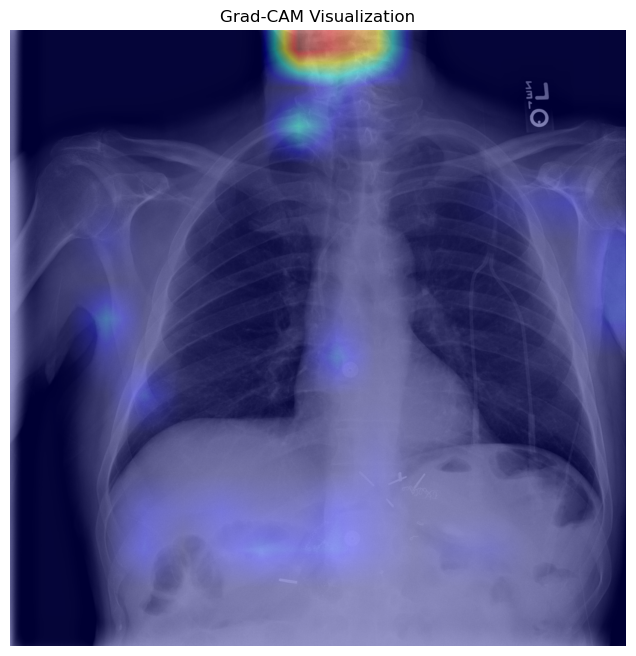

In [86]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Load the fine-tuned model
model_path = '/scratch/project_2010376/models/cnn_model_finetuned_guangzhou_final.keras'
model = tf.keras.models.load_model(model_path)

# Check image path exists
img_path = '/scratch/project_2010376/Pneumonia_Analysis_Dataset/pneumonia/00010334_010.png'
if not os.path.exists(img_path):
    raise FileNotFoundError(f"❌ Image not found at: {img_path}")

# Grad-CAM functions (same as before)
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, model, last_conv_layer_name='conv2d_22', alpha=0.4):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"❌ Failed to load image at: {img_path}")

    img_resized = cv2.resize(img, (64, 64)) / 255.0
    img_input = np.expand_dims(img_resized, axis=(0, -1))

    heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer_name)

    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    superimposed_img = cv2.addWeighted(img_rgb, 1 - alpha, heatmap_colored, alpha, 0)

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(superimposed_img[..., ::-1])
    plt.title('Grad-CAM Visualization')
    plt.show()

# Run Grad-CAM
display_gradcam(
    img_path=img_path,
    model=model,
    last_conv_layer_name='conv2d_22'
)


In [87]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np



In [93]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/scratch/project_2010376/Guangzhou_X_ray_dataset/processed_chest_xray/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

val_generator = val_datagen.flow_from_directory(
    '/scratch/project_2010376/Guangzhou_X_ray_dataset/processed_chest_xray/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

def create_benchmark_model(base_model_class, model_name):
    base_model = base_model_class(
        weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3))
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions, name=model_name)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# VGG16 Model
vgg_model = create_benchmark_model(VGG16, 'VGG16_Benchmark')
vgg_model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# ResNet50 Model
resnet_model = create_benchmark_model(ResNet50, 'ResNet50_Benchmark')
resnet_model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# Optional: Evaluate on test data
test_generator = val_datagen.flow_from_directory(
    '/scratch/project_2010376/Guangzhou_X_ray_dataset/processed_chest_xray/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb'
)

vgg_eval = vgg_model.evaluate(test_generator)
resnet_eval = resnet_model.evaluate(test_generator)

print(f'✅ VGG16 Test Accuracy: {vgg_eval[1]:.4f}')
print(f'✅ ResNet50 Test Accuracy: {resnet_eval[1]:.4f}')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/10


/scratch/project_2010376/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2303']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 603ms/step - accuracy: 0.7052 - loss: 0.5952 - val_accuracy: 0.5000 - val_loss: 0.7639
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 478ms/step - accuracy: 0.7600 - loss: 0.5002 - val_accuracy: 0.5000 - val_loss: 0.7124
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 495ms/step - accuracy: 0.7853 - loss: 0.4333 - val_accuracy: 0.5000 - val_loss: 0.6825
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 495ms/step - accuracy: 0.8298 - loss: 0.3806 - val_accuracy: 0.5000 - val_loss: 0.6723
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 488ms/step - accuracy: 0.8625 - loss: 0.3450 - val_accuracy: 0.5000 - val_loss: 0.7035
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 503ms/step - accuracy: 0.8770 - loss: 0.3140 - val_accuracy: 0.6250 - val_loss: 0.6458
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 506ms/step - accuracy: 0.8905 - loss: 0.2853 - val_accuracy: 0.6250 - val_loss: 0.6247
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 509ms/step - accuracy: 0.8947 - loss: 0.2717 - va

/scratch/project_2010376/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2326']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 558ms/step - accuracy: 0.6458 - loss: 0.6948 - val_accuracy: 0.5000 - val_loss: 0.7734
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 532ms/step - accuracy: 0.7587 - loss: 0.5184 - val_accuracy: 0.6250 - val_loss: 0.7190
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 554ms/step - accuracy: 0.7786 - loss: 0.4601 - val_accuracy: 0.6250 - val_loss: 0.7264
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 533ms/step - accuracy: 0.8021 - loss: 0.4222 - val_accuracy: 0.6250 - val_loss: 0.7553
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 538ms/step - accuracy: 0.8256 - loss: 0.3861 - val_accuracy: 0.6250 - val_loss: 0.6731
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 543ms/step - accuracy: 0.8388 - loss: 0.3667 - val_accuracy: 0.6875 - val_loss: 0.6619
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 545ms/step - accuracy: 0.8504 - loss: 0.3520 - val_accuracy: 0.6250 - val_loss: 0.7526
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 536ms/step - accuracy: 0.8655 - loss: 0.3287 - val

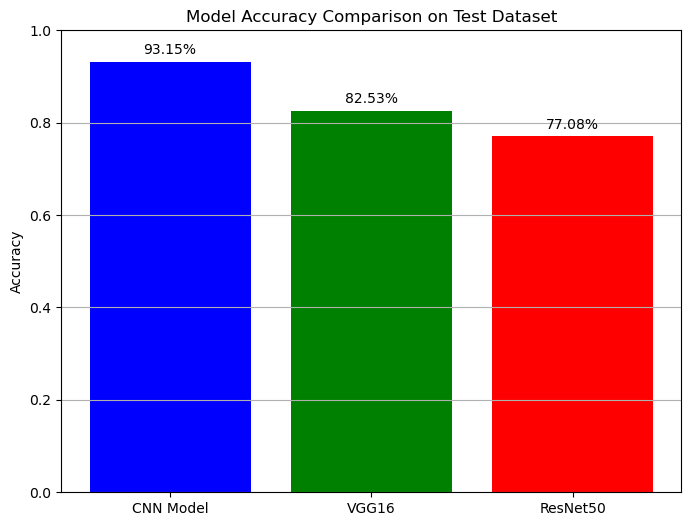

In [103]:
import matplotlib.pyplot as plt

# Replace these with your actual evaluation results!
custom_cnn_accuracy = 0.9315    # Example: Custom CNN accuracy on test set
vgg16_accuracy = 0.8253         # Example: VGG16 accuracy on test set
resnet50_accuracy = 0.7708      # Example: ResNet50 accuracy on test set

# Model names and accuracies
model_names = ['CNN Model', 'VGG16', 'ResNet50']
accuracies = [custom_cnn_accuracy, vgg16_accuracy, resnet50_accuracy]

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])

# Add accuracy labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2%}', ha='center', va='bottom')

plt.ylim(0, 1.0)
plt.title('Model Accuracy Comparison on Test Dataset')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.show()


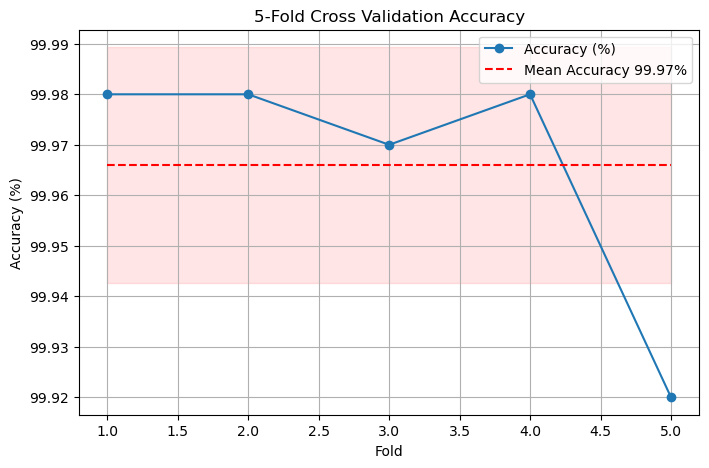

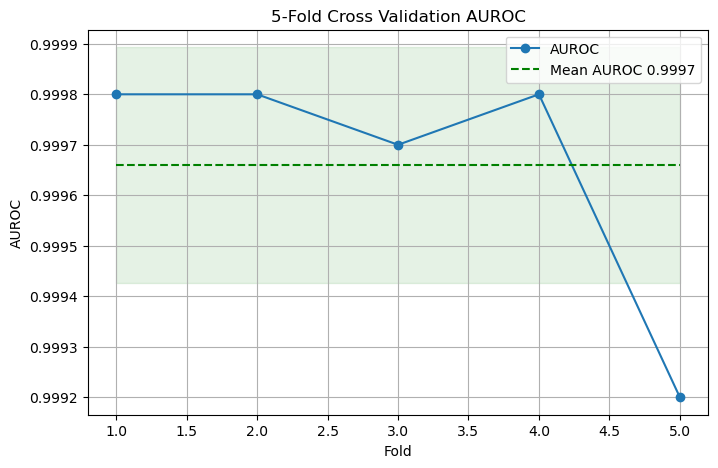

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics per fold
accuracy = [99.98, 99.98, 99.97, 99.98, 99.92]
auroc = [0.9998, 0.9998, 0.9997, 0.9998, 0.9992]

folds = [1, 2, 3, 4, 5]

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(folds, accuracy, marker='o', label='Accuracy (%)')
plt.hlines(np.mean(accuracy), 1, 5, colors='r', linestyles='dashed', label=f'Mean Accuracy {np.mean(accuracy):.2f}%')
plt.fill_between(folds, np.mean(accuracy)-np.std(accuracy), np.mean(accuracy)+np.std(accuracy), color='r', alpha=0.1)
plt.title('5-Fold Cross Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

# Plot AUROC
plt.figure(figsize=(8, 5))
plt.plot(folds, auroc, marker='o', label='AUROC')
plt.hlines(np.mean(auroc), 1, 5, colors='g', linestyles='dashed', label=f'Mean AUROC {np.mean(auroc):.4f}')
plt.fill_between(folds, np.mean(auroc)-np.std(auroc), np.mean(auroc)+np.std(auroc), color='g', alpha=0.1)
plt.title('5-Fold Cross Validation AUROC')
plt.xlabel('Fold')
plt.ylabel('AUROC')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics per fold
accuracy = [99.98, 99.98, 99.97, 99.98, 99.92]
auroc = [0.9998, 0.9998, 0.9997, 0.9998, 0.9992]

folds = [1, 2, 3, 4, 5]

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(folds, accuracy, marker='o', label='Accuracy (%)')
plt.hlines(np.mean(accuracy), 1, 5, colors='r', linestyles='dashed', label=f'Mean Accuracy {np.mean(accuracy):.2f}%')
plt.fill_between(folds, np.mean(accuracy)-np.std(accuracy), np.mean(accuracy)+np.std(accuracy), color='r', alpha=0.1)
plt.title('5-Fold Cross Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()